### IMDb - Data Wrangling

The IMDb data files that will initially be used for this project are as follows:
1. title.basics.tsv
2. title.akas.tsv
3. title.rating.tzv

These files were obtained on Feb 9, 2021 from the IMDb website https://www.imdb.com/interfaces/
The tsv files are located in the rawdata subdirectory, which are not on github due to their large filesize.  Follow the instructions in the README.md files for instructions to download / extract.

The data dictionary for the tsv files can be found in the datadict subdirectory (Documentation & Data Dictionary - IMDb TSV files.pdf). 

The goal of this project is to identify what makes a highly rated (6.5+ rating) MOVIE in the US using data from 1990-present.  These are the 
initial 3 filters that we will apply and will then merge them into a single dataframe.  We will check for duplicates along the way and after merging the dataframes.  We will also perform some additional cleaning and then write the final datafram out to a file for future steps (EDA, pre-processing and modeling).

In [1]:
# import our required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.algorithms import value_counts
from pathlib import Path
import datetime as dt

In [2]:
# The primary file is the title.basics.tsv file.  We will investigate that file first
print(Path('rawdata/title.basics.tsv').stat())

os.stat_result(st_mode=33261, st_ino=27364, st_dev=2064, st_nlink=1, st_uid=1000, st_gid=1000, st_size=649028657, st_atime=1614212837, st_mtime=1613786375, st_ctime=1613786375)


In [3]:
# The basics file is very large, so we will read in one chunk of 5000 and explore the results
basics_reader = pd.read_csv('rawdata/title.basics.tsv', sep='\t', chunksize=5000)
df_basics = next(basics_reader)

print(df_basics.head())

      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

   isAdult  startYear endYear runtimeMinutes                    genres  
0        0       1894      \N              1         Documentary,Short  
1        0       1892      \N              5           Animation,Short  
2        0       1892      \N              4  Animation,Comedy,Romance  
3        0       1892      \N             12           Animation,Short  
4        0       1893      \N              1              Comedy,Short  


In [4]:
print(df_basics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tconst          5000 non-null   object
 1   titleType       5000 non-null   object
 2   primaryTitle    5000 non-null   object
 3   originalTitle   5000 non-null   object
 4   isAdult         5000 non-null   int64 
 5   startYear       5000 non-null   int64 
 6   endYear         5000 non-null   object
 7   runtimeMinutes  5000 non-null   object
 8   genres          5000 non-null   object
dtypes: int64(2), object(7)
memory usage: 351.7+ KB
None


As we can see, all columns are non-null.  However from the data dictionary we know that IMDb does not provide missing values, instead they provide a value '\N' so this can be misleading.  Luckily, one of the filters we will be using (startYear) is defined as an int64 (at least in this first chunk).

Let's look at some additional info on titleType and startYear, we are looking for Movies from 1990 - present


In [5]:
print(df_basics['titleType'].value_counts())

short    4053
movie     947
Name: titleType, dtype: int64


In [6]:
print(df_basics['titleType'].describe())

count      5000
unique        2
top       short
freq       4053
Name: titleType, dtype: object


In [7]:
print(df_basics['startYear'].value_counts())

1914    1207
1913     977
1912     600
1911     508
1910     362
1909     306
1915     249
1908     157
1896     104
1900      82
1903      57
1907      49
1899      47
1898      45
1906      41
1897      37
1901      35
1902      35
1905      32
1904      22
1895      19
1916      13
1894       6
1892       3
1917       3
1918       1
1893       1
1936       1
1919       1
Name: startYear, dtype: int64


In [8]:
print(df_basics['startYear'].describe())

count    5000.000000
mean     1910.874200
std         4.481963
min      1892.000000
25%      1910.000000
50%      1912.000000
75%      1914.000000
max      1936.000000
Name: startYear, dtype: float64


This first chunk is not very helpful.  The best option at this point is to read the entire file and track the counts.  We'll do this using a generator function which works great for large files, and we'll track our counts in dictionaries, one for titleType and another for startYear

In [9]:
# create generator function for reading large files
def read_large_file(file_obj):
    '''A generator function to read large files lazily.'''

    # Loop indefitely until EOF
    while True:
        line = file_obj.readline()

        if not line:
            break

        yield line


In [10]:
titleTypeDict = {}
yearDict = {}

with open('rawdata/title.basics.tsv') as file:
    
    # skip the header record
    file.readline()

    # use generator to readlines and populate dictionary
    for line in read_large_file(file):
        row = line.split('\t')
        
        titleType = row[1]
        year = row[5]
        
        if titleType in titleTypeDict.keys():
            titleTypeDict[titleType] += 1
        else:
            titleTypeDict[titleType] = 1

        if year in yearDict.keys():
            yearDict[year] += 1
        else:
            yearDict[year] = 1



In [11]:
print(titleTypeDict)

{'short': 792881, 'movie': 567649, 'tvShort': 9588, 'tvMovie': 129888, 'tvSeries': 201161, 'tvEpisode': 5513333, 'tvMiniSeries': 35756, 'tvSpecial': 31369, 'video': 294787, 'videoGame': 27312, 'audiobook': 1, 'radioSeries': 1, 'episode': 1}


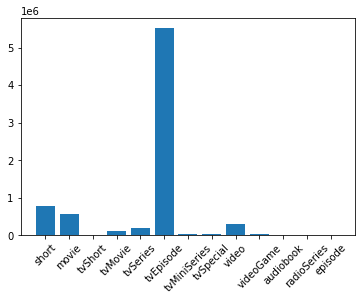

In [12]:
plt.bar(titleTypeDict.keys(), titleTypeDict.values())
plt.xticks(rotation=45)
plt.savefig('images/rawTitleType.png')
plt.show()
# the results show

The vase majority of titleType appear to be tvEpisodes, movie only appears to be around 600K-700K.  There are no '\N' values so cleaning on titleType will not be required.

In [13]:
print(yearDict)

{'1894': 98, '1892': 9, '1893': 3, '1895': 115, '1896': 844, '1898': 1792, '1897': 1362, '1900': 1859, '1899': 1817, '1901': 1768, '1904': 1838, '1903': 2676, '1902': 1808, '1905': 1705, '1912': 8707, '1907': 2483, '1906': 1860, '1908': 4283, '1910': 6409, '1909': 5432, '1914': 9317, '1911': 7706, '1913': 9771, '1915': 8551, '1919': 4116, '1916': 7019, '1917': 5606, '1918': 4724, '1936': 3354, '1925': 3376, '1920': 4492, '1922': 3598, '1921': 4227, '1923': 3033, '2019': 361552, '1924': 3093, '1928': 3484, '1926': 3397, '1927': 3508, '1929': 3644, '2000': 88108, '1993': 52456, '1935': 2904, '2014': 333619, '1930': 3183, '2004': 131112, '1942': 2404, '2011': 262654, '1934': 2971, '1931': 3287, '1932': 3071, '1939': 3021, '1937': 3569, '1933': 2914, '1950': 7264, '1938': 3388, '1951': 8557, '1945': 2027, '1946': 2486, '1940': 2597, '1944': 2032, '1949': 4915, '1947': 2936, '1941': 2486, '1952': 9281, '1970': 27731, '1957': 14042, '1943': 2187, '1959': 15394, '1948': 3601, '2001': 97357, '

Unfortunately the startYear contain '\N' values so we'll need to investigate this further.  However we do not know if these startYears are for titleType='movie', so we will run a similar loop as we did earlier and track a proper count of titleType='movie' AND startYear in our list of years as strings.




In [14]:
badYearCount = 0

with open('rawdata/title.basics.tsv') as file:
    
    # skip the header record
    file.readline()

    # use generator to readlines and populate dictionary
    for line in read_large_file(file):
        row = line.split('\t')
        
        titleType = row[1]
        year = row[5]
        
        if titleType == 'movie' and str(year) == "\\N":
            badYearCount += 1
            
print(badYearCount)           


70176


So there are movies with \N for startYear.  Based on prior queries there are also years well into the future (2115).  The best approach may be to load the file using dataframe chunks, filter on titleType = 'movie' and create a list of years as strings, including '\N' for filtering on startYear.  
Steps
1. Create string list of years including \N
2. import file to dataframe filtering on titleType = 'movie' and startYear in string list of years
3. Evaluate \N startYear values and clean / filter accordingly

In [15]:
# use list comprehension to create list of years as strings, including '\N' so we can evaluate in dataframe.  
# We'll include next year's releases to be safe

strYears = [str(year) for year in range(1990, dt.date.today().year + 2)]
strYears.append('\\N')
print(strYears)

['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '\\N']


In [16]:
# create an empty dataframe for results after filtering
df_titles_full = pd.DataFrame()

# load title.basics in chunks, filter and append to df_titles_full
df = pd.read_csv('rawdata/title.basics.tsv', sep='\t', chunksize=5000)
for df_titles in df:
    df_titles = df_titles[(df_titles['titleType'] == 'movie') & (df_titles['startYear'].astype(str).isin(strYears))]
    df_titles_full = df_titles_full.append(df_titles)


In [17]:
df_titles_full.shape

(363779, 9)

In [18]:
# Let's reread the file to see if our count of records (363779) is accurate
print(strYears)

['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '\\N']


In [19]:
goodCount = 0

with open('rawdata/title.basics.tsv') as file:
    
    # skip the header record
    file.readline()

    # use generator to readlines and populate dictionary
    for line in read_large_file(file):
        row = line.split('\t')
        
        titleType = row[1]
        year = row[5]
        
        if titleType == 'movie' and str(year) in strYears:
            goodCount += 1
            
print(goodCount)           


363779


In [20]:
# 363779 from both, results match.
# Let's investigate df_titles_full
df_titles_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363779 entries, 11061 to 7603677
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          363779 non-null  object
 1   titleType       363779 non-null  object
 2   primaryTitle    363779 non-null  object
 3   originalTitle   363779 non-null  object
 4   isAdult         363779 non-null  object
 5   startYear       363779 non-null  object
 6   endYear         363779 non-null  object
 7   runtimeMinutes  363779 non-null  object
 8   genres          363779 non-null  object
dtypes: object(9)
memory usage: 27.8+ MB


In [21]:
df_titles_full.describe()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
count,363779,363779,363779,363779,363779,363779,363779,363779,363779
unique,363779,1,319884,326208,4,48,1,437,1296
top,tt0102237,movie,Home,Broken,0,\N,\N,\N,Documentary
freq,1,363779,45,42,360765,70176,363779,131884,66941


The results of describe() are interesting...  tconst (titleId) are all unique, so that's good.  However startYear='\N' has the highest frequency so we need to investigate that, there are 70176 occurences of that.

In [22]:
print(df_titles_full[df_titles_full['startYear'] == '\\N'].head(20))

           tconst titleType                      primaryTitle  \
100592  tt0102844     movie                          Saudagar   
105792  tt0108144     movie                               Sir   
109176  tt0111597     movie                   The Veiled Hope   
110039  tt0112485     movie                    Betaaj Badshah   
115874  tt0118530     movie                                18   
118068  tt0120892     movie                     Winding Stair   
118206  tt0121062     movie              Alexandru Lapusneanu   
118281  tt0121158     movie                          Complica   
118291  tt0121172     movie                       Cuo zai cuo   
118292  tt0121173     movie             The Curly-Headed Dude   
118309  tt0121191     movie                Deadly Confessions   
118319  tt0121202     movie                 Devotion of a Boy   
118353  tt0121243     movie                Encouraging Melody   
118443  tt0121347     movie                         Havergill   
118476  tt0121385     mov

While some of these first 20 titles are English, some are also foreign.  There's really nothing in these that can help with determining whether to keep or drop these so we will keep them for now.

Another interesting point is that there are 4 unique values for isAdult.  While not specifically stated in our mission, we should probable stick with non-Adult films.  Let's investigate.

In [23]:
df_titles_full['isAdult'].value_counts()

0    360765
1      2822
0       185
1         7
Name: isAdult, dtype: int64

There are four values but they are 2 '0' and 2 '1'.  Let's review the values.

In [24]:
df_titles_full['isAdult'].unique()

array([0, 1, '0', '1'], dtype=object)

unique values returns 0 and 1 as both int and strings.  we'll convert to int.

In [25]:
df_titles_full['isAdult'] = df_titles_full['isAdult'].astype(int)
df_titles_full['isAdult'].unique()

array([0, 1])

In [26]:
print(df_titles_full[df_titles_full['isAdult'] == 1].head(50))

           tconst titleType                      primaryTitle  \
88051   tt0090000     movie              Wet Sexes in the Sun   
93949   tt0096038     movie            Saturday Night Special   
94640   tt0096749     movie                        Abatjour 2   
94653   tt0096763     movie                          Adultery   
95840   tt0097979     movie                    Nightdreams II   
96897   tt0099066     movie                 Savage Attraction   
97020   tt0099192     movie                       Bush Pilots   
97073   tt0099246     movie     Cheeks 4: A Backstreet Affair   
97094   tt0099267     movie                     World Cup '90   
97477   tt0099658     movie                Gioco di seduzione   
97484   tt0099665     movie                    Girls and Guns   
97585   tt0099769     movie                     Hidden Desire   
97707   tt0099897     movie             Josefine Mutzenbacher   
97750   tt0099941     movie                 Kinky Business II   
98358   tt0100570     mov

We don't want to keep these based on the title names so let's filter them out also

In [27]:
df_titles_full = df_titles_full[df_titles_full['isAdult'] == 0]

In [28]:
df_titles_full.shape

(360950, 9)

In [29]:
df_titles_full['isAdult'].value_counts()

0    360950
Name: isAdult, dtype: int64

In [30]:
# Let's review again
df_titles_full.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
11061,tt0011216,movie,Spanish Fiesta,La fête espagnole,0,2019,\N,67,Drama
11638,tt0011801,movie,Tötet nicht mehr,Tötet nicht mehr,0,2019,\N,\N,"Action,Crime"
15183,tt0015414,movie,La tierra de los toros,La tierra de los toros,0,2000,\N,60,\N
15491,tt0015724,movie,Dama de noche,Dama de noche,0,1993,\N,102,"Drama,Mystery,Romance"
16661,tt0016906,movie,Frivolinas,Frivolinas,0,2014,\N,80,"Comedy,Musical"


In [31]:
df_titles_full.describe(include='all')

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
count,360950,360950,360950,360950,360950.0,360950,360950,360950,360950
unique,360950,1,317307,323606,NaN,47,1,436,1241
top,tt0102237,movie,Home,Broken,NaN,\N,\N,\N,Documentary
freq,1,360950,45,42,NaN,70046,360950,130271,66935
mean,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [32]:
df_titles_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360950 entries, 11061 to 7603677
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tconst          360950 non-null  object
 1   titleType       360950 non-null  object
 2   primaryTitle    360950 non-null  object
 3   originalTitle   360950 non-null  object
 4   isAdult         360950 non-null  int64 
 5   startYear       360950 non-null  object
 6   endYear         360950 non-null  object
 7   runtimeMinutes  360950 non-null  object
 8   genres          360950 non-null  object
dtypes: int64(1), object(8)
memory usage: 27.5+ MB


We've done enough with this primary data set for now.  We'll evaluate Nulls (\N) values and duplicates as we merge in the other datasets.

The next dataset we will look at is the title.akas.tsv file.  The file has multipe records for each title across different regions.  Based on what we are looking for we will need to filter this dataset on the region = 'US', but will also have to take into account any '\N' values.  First we'll read in the first chunk of 5000 and evaluate.

In [33]:
print(Path('rawdata/title.akas.tsv').stat())

os.stat_result(st_mode=33261, st_ino=27300, st_dev=2064, st_nlink=1, st_uid=1000, st_gid=1000, st_size=1244389027, st_atime=1614213068, st_mtime=1613786369, st_ctime=1613786369)


In [34]:
akas_reader = pd.read_csv('rawdata/title.akas.tsv', sep='\t', chunksize=5000)
df_akas = next(akas_reader)

print(df_akas.head(50))

      titleId  ordering                       title region language  \
0   tt0000001         1                  Карменсіта     UA       \N   
1   tt0000001         2                  Carmencita     DE       \N   
2   tt0000001         3   Carmencita - spanyol tánc     HU       \N   
3   tt0000001         4                  Καρμενσίτα     GR       \N   
4   tt0000001         5                  Карменсита     RU       \N   
5   tt0000001         6                  Carmencita     US       \N   
6   tt0000001         7                  Carmencita     \N       \N   
7   tt0000001         8                     カルメンチータ     JP       ja   
8   tt0000002         1      Le clown et ses chiens     \N       \N   
9   tt0000002         2           A bohóc és kutyái     HU       \N   
10  tt0000002         3      Le clown et ses chiens     FR       \N   
11  tt0000002         4   Der Clown und seine Hunde     DE       \N   
12  tt0000002         5       Clovnul si cainii sai     RO       \N   
13  tt

In [35]:
df_akas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   titleId          5000 non-null   object
 1   ordering         5000 non-null   int64 
 2   title            5000 non-null   object
 3   region           5000 non-null   object
 4   language         5000 non-null   object
 5   types            5000 non-null   object
 6   attributes       5000 non-null   object
 7   isOriginalTitle  5000 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 312.6+ KB


Next we'll start by running this file through the generator function to create a dictionary and counts of the various regions.

In [36]:
regionDict = {}

with open('rawdata/title.akas.tsv') as file:
    
    # skip the header record
    file.readline()

    # use generator to readlines and populate dictionary
    for line in read_large_file(file):
        row = line.split('\t')
        region = row[3]

        if region in regionDict.keys():
            regionDict[region] += 1
        else:
            regionDict[region] = 1

print(regionDict)

{'UA': 17509, 'DE': 3060767, 'HU': 66507, 'GR': 81364, 'RU': 73974, 'US': 1164759, '\\N': 604420, 'JP': 3093235, 'FR': 3103881, 'RO': 23313, 'GB': 312822, 'PT': 2963736, 'RS': 20350, 'ES': 3033914, 'UY': 6592, 'IT': 3018544, 'AR': 50896, 'FI': 73975, 'PL': 65289, 'BR': 95093, 'DK': 50476, 'TR': 38310, 'XWW': 140690, 'XEU': 4860, 'SK': 6370, 'CZ': 15599, 'SE': 55214, 'MX': 79683, 'NO': 27701, 'XYU': 13871, 'AT': 26601, 'VE': 8889, 'CSHH': 8726, 'SI': 8403, 'AU': 94405, 'TW': 18978, 'LT': 9496, 'IN': 3010692, 'CA': 166020, 'NL': 38427, 'CO': 7305, 'IR': 10376, 'BG': 25161, 'BE': 25553, 'DZ': 840, 'CH': 10316, 'NZ': 9337, 'BF': 209, 'XWG': 49101, 'VN': 4706, 'XSA': 123, 'SUHH': 31335, 'EE': 5953, 'IS': 1999, 'HR': 10905, 'DDDE': 8861, 'XKO': 170, 'CL': 8829, 'PE': 6863, 'EG': 5174, 'HK': 23215, 'GE': 1287, 'BY': 555, 'BA': 1812, 'PA': 611, 'CN': 19009, 'TJ': 47, 'XSI': 7, 'YUCS': 687, 'IE': 12958, 'IL': 11291, 'LV': 4183, 'CU': 2213, 'AL': 1912, 'BO': 582, 'ID': 4073, 'ZA': 6292, 'KR': 14

There are US values (1164759) as well as \N values (604420).  We'll read in the file and filter for these 2 values so we can investigate the \N values.  

In [37]:
# create a list for US and \N
region_list = ['US', '\\N']

# create an empty dataframe for results after filtering
df_akas = pd.DataFrame()

# load title.akas in chunks, filter and append to df_akas
df = pd.read_csv('rawdata/title.akas.tsv', sep='\t', chunksize=5000)
for df_aka in df:
    df_aka = df_aka[(df_aka['region'].isin(region_list))]
    df_akas = df_akas.append(df_aka)
    
df_akas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1769064 entries, 5 to 25154194
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   titleId          object
 1   ordering         int64 
 2   title            object
 3   region           object
 4   language         object
 5   types            object
 6   attributes       object
 7   isOriginalTitle  object
dtypes: int64(1), object(7)
memory usage: 121.5+ MB


In [38]:
df_akas.shape

(1769064, 8)

Now that we have the akas file in a dataframe, we really cannot (or should not) do any further investigation on duplicates, etc because we do not know if these are movies within our year range.  We will merge (inner join) with our primary dataframe first and then investigate.   

In [39]:
df_movies = pd.merge(df_titles_full, df_akas, left_on='tconst', right_on='titleId', how='inner')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341144 entries, 0 to 341143
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           341144 non-null  object
 1   titleType        341144 non-null  object
 2   primaryTitle     341144 non-null  object
 3   originalTitle    341144 non-null  object
 4   isAdult          341144 non-null  int64 
 5   startYear        341144 non-null  object
 6   endYear          341144 non-null  object
 7   runtimeMinutes   341144 non-null  object
 8   genres           341144 non-null  object
 9   titleId          341144 non-null  object
 10  ordering         341144 non-null  int64 
 11  title            341144 non-null  object
 12  region           341144 non-null  object
 13  language         341144 non-null  object
 14  types            341144 non-null  object
 15  attributes       341144 non-null  object
 16  isOriginalTitle  341144 non-null  object
dtypes: int64(2

In [40]:
df_movies.shape

(341144, 17)

Now we check on duplicated movie ids

In [42]:
# find duplicates using tconst.  return tconst, region, title, isOriginalTitle, primaryTitle, startYear.  region, title, 
# and isOriginalTitle are from merged akas file
duplicates = df_movies.duplicated('tconst', keep=False)
duplicate_movies = df_movies[duplicates].sort_values(['tconst', 'region'])
print(duplicate_movies[['tconst', 'region', 'title', 'isOriginalTitle', 'primaryTitle', 'startYear']].head(50))

       tconst region                                      title  \
3   tt0015724     \N                              Dama de noche   
4   tt0015724     \N                          Lady of the Night   
6   tt0019996     \N                                    Hongxia   
7   tt0019996     \N                             Heroine in Red   
9   tt0035423     US                           Kate and Leopold   
10  tt0035423     US                             Kate & Leopold   
8   tt0035423     \N                             Kate & Leopold   
12  tt0036177     US              The Life of Matsu the Untamed   
11  tt0036177     \N                         Muhomatsu no issho   
13  tt0059325     US                                Born in '45   
14  tt0059325     \N                               Jahrgang '45   
16  tt0059900     US                When You Grow Up, Dear Adam   
15  tt0059900     \N             Wenn du groß bist, lieber Adam   
17  tt0062336     \N  El Tango del Viudo y Su Espejo Deformant

In [43]:
duplicate_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178824 entries, 3 to 341140
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           178824 non-null  object
 1   titleType        178824 non-null  object
 2   primaryTitle     178824 non-null  object
 3   originalTitle    178824 non-null  object
 4   isAdult          178824 non-null  int64 
 5   startYear        178824 non-null  object
 6   endYear          178824 non-null  object
 7   runtimeMinutes   178824 non-null  object
 8   genres           178824 non-null  object
 9   titleId          178824 non-null  object
 10  ordering         178824 non-null  int64 
 11  title            178824 non-null  object
 12  region           178824 non-null  object
 13  language         178824 non-null  object
 14  types            178824 non-null  object
 15  attributes       178824 non-null  object
 16  isOriginalTitle  178824 non-null  object
dtypes: int64(2

In [44]:
# look at types
duplicate_movies[duplicate_movies['region']=='US']['types'].value_counts()

\N               37684
imdbDisplay      32099
working           6264
alternative       2298
dvd                942
festival           650
video              550
tv                 142
original             5
tvworking           2
dvdworking          1
videoworking        1
tvvideo             1
dvdvideo            1
Name: types, dtype: int64

Some duplicates both have region \N while other duplicates have 1 region \N and the other US.  There are some dups with region = US but different titles.  Unfortunately there is no clear cut logic to apply so we will drop anything with \N region and recheck.

In [45]:
df_movies['region'].value_counts()

\N    173859
US    167285
Name: region, dtype: int64

In [46]:
df_movies = df_movies[df_movies['region'] == 'US']
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167285 entries, 9 to 341143
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           167285 non-null  object
 1   titleType        167285 non-null  object
 2   primaryTitle     167285 non-null  object
 3   originalTitle    167285 non-null  object
 4   isAdult          167285 non-null  int64 
 5   startYear        167285 non-null  object
 6   endYear          167285 non-null  object
 7   runtimeMinutes   167285 non-null  object
 8   genres           167285 non-null  object
 9   titleId          167285 non-null  object
 10  ordering         167285 non-null  int64 
 11  title            167285 non-null  object
 12  region           167285 non-null  object
 13  language         167285 non-null  object
 14  types            167285 non-null  object
 15  attributes       167285 non-null  object
 16  isOriginalTitle  167285 non-null  object
dtypes: int64(2

In [47]:
# check again for duplicate tconst
duplicates = df_movies.duplicated('tconst', keep=False)
duplicate_movies = df_movies[duplicates].sort_values('tconst')
print(duplicate_movies[['tconst', 'region', 'title', 'isOriginalTitle', 'primaryTitle']].head(50))

        tconst region                                    title  \
9    tt0035423     US                         Kate and Leopold   
10   tt0035423     US                           Kate & Leopold   
30   tt0081145     US                      Taking Gary Feldman   
31   tt0081145     US                           Me and the Kid   
35   tt0084015     US                       Moon Over Paradise   
37   tt0084015     US                         Goodbye Paradise   
45   tt0088751     US            Attack of the B-Movie Monster   
47   tt0088751     US                        The Naked Monster   
104  tt0095745     US       Black and White: A Warrior's Quest   
103  tt0095745     US                          Ninja Vengeance   
105  tt0095821     US                        Caged in Paradiso   
107  tt0095821     US                         Maximum Security   
111  tt0095878     US                             Pledge Night   
113  tt0095878     US                         A Hazing in Hell   
148  tt009

In [48]:
duplicate_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22217 entries, 9 to 340684
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tconst           22217 non-null  object
 1   titleType        22217 non-null  object
 2   primaryTitle     22217 non-null  object
 3   originalTitle    22217 non-null  object
 4   isAdult          22217 non-null  int64 
 5   startYear        22217 non-null  object
 6   endYear          22217 non-null  object
 7   runtimeMinutes   22217 non-null  object
 8   genres           22217 non-null  object
 9   titleId          22217 non-null  object
 10  ordering         22217 non-null  int64 
 11  title            22217 non-null  object
 12  region           22217 non-null  object
 13  language         22217 non-null  object
 14  types            22217 non-null  object
 15  attributes       22217 non-null  object
 16  isOriginalTitle  22217 non-null  object
dtypes: int64(2), object(15)
memory

In [49]:
duplicate_movies.head(50)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
9,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance",tt0035423,33,Kate and Leopold,US,\N,\N,alternative spelling,0
10,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance",tt0035423,35,Kate & Leopold,US,\N,\N,\N,0
30,tt0081145,movie,Me and the Kid,Me and the Kid,0,1993,\N,94,"Comedy,Crime,Drama",tt0081145,12,Taking Gary Feldman,US,\N,working,\N,0
31,tt0081145,movie,Me and the Kid,Me and the Kid,0,1993,\N,94,"Comedy,Crime,Drama",tt0081145,6,Me and the Kid,US,\N,\N,\N,0
35,tt0084015,movie,Goodbye Paradise,Goodbye Paradise,0,1991,\N,101,Drama,tt0084015,1,Moon Over Paradise,US,\N,video,\N,0
37,tt0084015,movie,Goodbye Paradise,Goodbye Paradise,0,1991,\N,101,Drama,tt0084015,3,Goodbye Paradise,US,\N,\N,\N,0
45,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,\N,100,"Comedy,Horror,Sci-Fi",tt0088751,1,Attack of the B-Movie Monster,US,\N,working,\N,0
47,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,\N,100,"Comedy,Horror,Sci-Fi",tt0088751,4,The Naked Monster,US,\N,\N,\N,0
104,tt0095745,movie,Ninja Vengeance,Ninja Vengeance,0,1993,\N,87,"Action,Drama",tt0095745,7,Black and White: A Warrior's Quest,US,\N,working,\N,0
103,tt0095745,movie,Ninja Vengeance,Ninja Vengeance,0,1993,\N,87,"Action,Drama",tt0095745,5,Ninja Vengeance,US,\N,\N,\N,0


There really isn't any obvious logic that would dictate which US region title to keep.  For this reason, we are going to drop dupliates (based on tconst) and keep the first.

In [50]:
df_movies = df_movies.drop_duplicates(subset='tconst', keep='first')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154711 entries, 9 to 341143
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           154711 non-null  object
 1   titleType        154711 non-null  object
 2   primaryTitle     154711 non-null  object
 3   originalTitle    154711 non-null  object
 4   isAdult          154711 non-null  int64 
 5   startYear        154711 non-null  object
 6   endYear          154711 non-null  object
 7   runtimeMinutes   154711 non-null  object
 8   genres           154711 non-null  object
 9   titleId          154711 non-null  object
 10  ordering         154711 non-null  int64 
 11  title            154711 non-null  object
 12  region           154711 non-null  object
 13  language         154711 non-null  object
 14  types            154711 non-null  object
 15  attributes       154711 non-null  object
 16  isOriginalTitle  154711 non-null  object
dtypes: int64(2

In [51]:
df_movies.describe(include='all')

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
count,154711,154711,154711,154711,154711.0,154711,154711,154711,154711,154711,154711.000000,154711,154711,154711,154711,154711,154711.0
unique,154711,1,136465,137767,NaN,41,1,358,1095,154711,NaN,136268,1,4,11,78,5.0
top,tt2446318,movie,Broken,Broken,NaN,\N,\N,\N,Drama,tt2446318,NaN,Broken,US,\N,\N,\N,0.0
freq,1,154711,28,28,NaN,44991,154711,61869,22811,1,NaN,29,154711,154198,117802,150625,102495.0
mean,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.755337,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,4.499530,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN


The describe "all" shows tconst has 154711 count and 154711 unique, so we no longer have any duplicates

Now we'll merge in our last dataset for ratings.  This dataset only has title ids, avg rating and number of votes.

In [52]:
df_ratings = pd.DataFrame()

# load title.basics in chunks, filter and append to df_titles_full
df = pd.read_csv('rawdata/title.ratings.tsv', sep='\t', chunksize=5000)
for df_rate in df:
    df_ratings = df_ratings.append(df_rate)
    
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121829 entries, 0 to 1121828
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1121829 non-null  object 
 1   averageRating  1121829 non-null  float64
 2   numVotes       1121829 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 25.7+ MB


In [53]:
# merge with df_movies
df_movie_ratings = pd.merge(df_movies, df_ratings, on='tconst', how='left')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154711 entries, 9 to 341143
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tconst           154711 non-null  object
 1   titleType        154711 non-null  object
 2   primaryTitle     154711 non-null  object
 3   originalTitle    154711 non-null  object
 4   isAdult          154711 non-null  int64 
 5   startYear        154711 non-null  object
 6   endYear          154711 non-null  object
 7   runtimeMinutes   154711 non-null  object
 8   genres           154711 non-null  object
 9   titleId          154711 non-null  object
 10  ordering         154711 non-null  int64 
 11  title            154711 non-null  object
 12  region           154711 non-null  object
 13  language         154711 non-null  object
 14  types            154711 non-null  object
 15  attributes       154711 non-null  object
 16  isOriginalTitle  154711 non-null  object
dtypes: int64(2

In [54]:
df_movie_ratings.describe(include='all')

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
count,154711,154711,154711,154711,154711.0,154711,154711,154711,154711,154711,154711.000000,154711,154711,154711,154711,154711,154711.0,71030.000000,7.103000e+04
unique,154711,1,136465,137767,NaN,41,1,358,1095,154711,NaN,136268,1,4,11,78,5.0,NaN,NaN
top,tt2446318,movie,Broken,Broken,NaN,\N,\N,\N,Drama,tt2446318,NaN,Broken,US,\N,\N,\N,0.0,NaN,NaN
freq,1,154711,28,28,NaN,44991,154711,61869,22811,1,NaN,29,154711,154198,117802,150625,102495.0,NaN,NaN
mean,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.755337,NaN,NaN,NaN,NaN,NaN,NaN,6.117770,9.818230e+03
std,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,4.499530,NaN,NaN,NaN,NaN,NaN,NaN,1.493007,5.702007e+04
min,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,5.000000e+00
25%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.200000,2.300000e+01
50%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.300000,1.280000e+02
75%,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,7.200000,1.044000e+03


The count and unique values of tconst has not changed so we can assume no duplicates have been introduced.

In [55]:
df_movie_ratings.head(50)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,titleId,ordering,title,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001,\N,118,"Comedy,Fantasy,Romance",tt0035423,33,Kate and Leopold,US,\N,\N,alternative spelling,0,6.4,79054.0
1,tt0036177,movie,Muhomatsu no issho,Muhomatsu no issho,0,2008,\N,100,"Action,Adventure",tt0036177,3,The Life of Matsu the Untamed,US,\N,alternative,\N,0,7.3,75.0
2,tt0059325,movie,Born in '45,Jahrgang '45,0,1990,\N,100,"Drama,Romance",tt0059325,5,Born in '45,US,\N,\N,\N,0,6.5,208.0
3,tt0059900,movie,"Wenn du groß bist, lieber Adam","Wenn du groß bist, lieber Adam",0,1990,\N,78,"Drama,Fantasy",tt0059900,4,"When You Grow Up, Dear Adam",US,\N,video,\N,0,6.8,26.0
4,tt0064730,movie,Japan Organized Crime Boss,Nihon boryoku-dan: Kumicho,0,2000,\N,97,"Action,Crime",tt0064730,4,Japan Organized Crime Boss,US,\N,\N,\N,0,7.0,172.0
5,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018,\N,122,Drama,tt0069049,3,The Other Side of the Wind,US,\N,imdbDisplay,\N,0,6.8,6327.0
6,tt0081145,movie,Me and the Kid,Me and the Kid,0,1993,\N,94,"Comedy,Crime,Drama",tt0081145,12,Taking Gary Feldman,US,\N,working,\N,0,5.5,243.0
7,tt0081721,movie,Vincent and Me,Vincent et moi,0,1990,\N,100,"Drama,Family,Fantasy",tt0081721,1,Vincent and Me,US,\N,imdbDisplay,\N,0,6.3,293.0
8,tt0084015,movie,Goodbye Paradise,Goodbye Paradise,0,1991,\N,101,Drama,tt0084015,1,Moon Over Paradise,US,\N,video,\N,0,7.3,39.0
9,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005,\N,100,"Comedy,Horror,Sci-Fi",tt0088751,1,Attack of the B-Movie Monster,US,\N,working,\N,0,5.4,278.0


Now that we have all 3 datasets merged into one we need to do some cleanup.  First we can drop columns:
1. There are 3 titles, primaryTitle and originalTitle from the basics dataset and title from the akas (region) dataset.  We'll keep the primaryTitle
2. isAdult - we previously filtered to omit adult movies, all values are 0
3. endYear - based on the data dictionary from IMDb, this field is for tv episodes or similar types, movies do not have an endYear
4. titleId from akas (region) file, this value is the same as the basics tconst
5. ordering - from the akas file, this was a simple integer for each regional version of a title.  As we've already removed duplicates this value serves no purpose


In [56]:
df_movie_ratings = df_movie_ratings.drop(['originalTitle', 'isAdult', 'title', 'endYear', 'titleId', 'ordering'], axis=1)
df_movie_ratings.head(50)

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
0,tt0035423,movie,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",US,\N,\N,alternative spelling,0,6.4,79054.0
1,tt0036177,movie,Muhomatsu no issho,2008,100,"Action,Adventure",US,\N,alternative,\N,0,7.3,75.0
2,tt0059325,movie,Born in '45,1990,100,"Drama,Romance",US,\N,\N,\N,0,6.5,208.0
3,tt0059900,movie,"Wenn du groß bist, lieber Adam",1990,78,"Drama,Fantasy",US,\N,video,\N,0,6.8,26.0
4,tt0064730,movie,Japan Organized Crime Boss,2000,97,"Action,Crime",US,\N,\N,\N,0,7.0,172.0
5,tt0069049,movie,The Other Side of the Wind,2018,122,Drama,US,\N,imdbDisplay,\N,0,6.8,6327.0
6,tt0081145,movie,Me and the Kid,1993,94,"Comedy,Crime,Drama",US,\N,working,\N,0,5.5,243.0
7,tt0081721,movie,Vincent and Me,1990,100,"Drama,Family,Fantasy",US,\N,imdbDisplay,\N,0,6.3,293.0
8,tt0084015,movie,Goodbye Paradise,1991,101,Drama,US,\N,video,\N,0,7.3,39.0
9,tt0088751,movie,The Naked Monster,2005,100,"Comedy,Horror,Sci-Fi",US,\N,working,\N,0,5.4,278.0


Now we will replace all '\N' values with na so we can do some additional investigation

In [57]:
df_movie_ratings = df_movie_ratings.replace('\\N', np.NaN)
df_movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154711 entries, 0 to 154710
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           154711 non-null  object 
 1   titleType        154711 non-null  object 
 2   primaryTitle     154711 non-null  object 
 3   startYear        109720 non-null  object 
 4   runtimeMinutes   92842 non-null   object 
 5   genres           149884 non-null  object 
 6   region           154711 non-null  object 
 7   language         513 non-null     object 
 8   types            36909 non-null   object 
 9   attributes       4086 non-null    object 
 10  isOriginalTitle  154695 non-null  object 
 11  averageRating    71030 non-null   float64
 12  numVotes         71030 non-null   float64
dtypes: float64(2), object(11)
memory usage: 16.5+ MB


In [58]:
df_movie_ratings.head(50)

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,region,language,types,attributes,isOriginalTitle,averageRating,numVotes
0,tt0035423,movie,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",US,NaN,NaN,alternative spelling,0,6.4,79054.0
1,tt0036177,movie,Muhomatsu no issho,2008,100,"Action,Adventure",US,NaN,alternative,NaN,0,7.3,75.0
2,tt0059325,movie,Born in '45,1990,100,"Drama,Romance",US,NaN,NaN,NaN,0,6.5,208.0
3,tt0059900,movie,"Wenn du groß bist, lieber Adam",1990,78,"Drama,Fantasy",US,NaN,video,NaN,0,6.8,26.0
4,tt0064730,movie,Japan Organized Crime Boss,2000,97,"Action,Crime",US,NaN,NaN,NaN,0,7.0,172.0
5,tt0069049,movie,The Other Side of the Wind,2018,122,Drama,US,NaN,imdbDisplay,NaN,0,6.8,6327.0
6,tt0081145,movie,Me and the Kid,1993,94,"Comedy,Crime,Drama",US,NaN,working,NaN,0,5.5,243.0
7,tt0081721,movie,Vincent and Me,1990,100,"Drama,Family,Fantasy",US,NaN,imdbDisplay,NaN,0,6.3,293.0
8,tt0084015,movie,Goodbye Paradise,1991,101,Drama,US,NaN,video,NaN,0,7.3,39.0
9,tt0088751,movie,The Naked Monster,2005,100,"Comedy,Horror,Sci-Fi",US,NaN,working,NaN,0,5.4,278.0


In [59]:
# Review null counts / percentages
missing = pd.concat([df_movie_ratings.isnull().sum(), 100 * df_movie_ratings.isnull().mean()], axis=1).sort_values(by=[0,1], ascending=False)
missing.columns=['count', '%']
missing.groupby(by=['count', '%'])
missing

,count,%
language,154198,99.668414
attributes,150625,97.358947
types,117802,76.143261
averageRating,83681,54.088591
numVotes,83681,54.088591
runtimeMinutes,61869,39.990046
startYear,44991,29.080673
genres,4827,3.120011
isOriginalTitle,16,0.010342
tconst,0,0.000000


Language and atibutes both have over 95% null values, and types is at approx 76%.  Average Rating and Number of Votes are both around 54%, but those are going to important information in our analysis.  For now it should be safe to drop language and attributes

In [60]:
df_movie_ratings = df_movie_ratings.drop(['language', 'attributes'], axis=1)
df_movie_ratings.head(50)

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,region,types,isOriginalTitle,averageRating,numVotes
0,tt0035423,movie,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",US,NaN,0,6.4,79054.0
1,tt0036177,movie,Muhomatsu no issho,2008,100,"Action,Adventure",US,alternative,0,7.3,75.0
2,tt0059325,movie,Born in '45,1990,100,"Drama,Romance",US,NaN,0,6.5,208.0
3,tt0059900,movie,"Wenn du groß bist, lieber Adam",1990,78,"Drama,Fantasy",US,video,0,6.8,26.0
4,tt0064730,movie,Japan Organized Crime Boss,2000,97,"Action,Crime",US,NaN,0,7.0,172.0
5,tt0069049,movie,The Other Side of the Wind,2018,122,Drama,US,imdbDisplay,0,6.8,6327.0
6,tt0081145,movie,Me and the Kid,1993,94,"Comedy,Crime,Drama",US,working,0,5.5,243.0
7,tt0081721,movie,Vincent and Me,1990,100,"Drama,Family,Fantasy",US,imdbDisplay,0,6.3,293.0
8,tt0084015,movie,Goodbye Paradise,1991,101,Drama,US,video,0,7.3,39.0
9,tt0088751,movie,The Naked Monster,2005,100,"Comedy,Horror,Sci-Fi",US,working,0,5.4,278.0


In [61]:
# Let's also drop Region, they are all US based on previous filtering
df_movie_ratings = df_movie_ratings.drop(['region'], axis=1)
df_movie_ratings.head(50)

,tconst,titleType,primaryTitle,startYear,runtimeMinutes,genres,types,isOriginalTitle,averageRating,numVotes
0,tt0035423,movie,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",NaN,0,6.4,79054.0
1,tt0036177,movie,Muhomatsu no issho,2008,100,"Action,Adventure",alternative,0,7.3,75.0
2,tt0059325,movie,Born in '45,1990,100,"Drama,Romance",NaN,0,6.5,208.0
3,tt0059900,movie,"Wenn du groß bist, lieber Adam",1990,78,"Drama,Fantasy",video,0,6.8,26.0
4,tt0064730,movie,Japan Organized Crime Boss,2000,97,"Action,Crime",NaN,0,7.0,172.0
5,tt0069049,movie,The Other Side of the Wind,2018,122,Drama,imdbDisplay,0,6.8,6327.0
6,tt0081145,movie,Me and the Kid,1993,94,"Comedy,Crime,Drama",working,0,5.5,243.0
7,tt0081721,movie,Vincent and Me,1990,100,"Drama,Family,Fantasy",imdbDisplay,0,6.3,293.0
8,tt0084015,movie,Goodbye Paradise,1991,101,Drama,video,0,7.3,39.0
9,tt0088751,movie,The Naked Monster,2005,100,"Comedy,Horror,Sci-Fi",working,0,5.4,278.0


The last thing we want to do is to split the genre column, it is currently a list of genres and we would like each genre to be its own column.

In [62]:
dummy = df_movie_ratings['genres'].str.get_dummies(',')
dummy.head(50)


,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [63]:
df_movie_ratings = pd.concat([df_movie_ratings, dummy], axis=1)
df_movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154711 entries, 0 to 154710
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           154711 non-null  object 
 1   titleType        154711 non-null  object 
 2   primaryTitle     154711 non-null  object 
 3   startYear        109720 non-null  object 
 4   runtimeMinutes   92842 non-null   object 
 5   genres           149884 non-null  object 
 6   types            36909 non-null   object 
 7   isOriginalTitle  154695 non-null  object 
 8   averageRating    71030 non-null   float64
 9   numVotes         71030 non-null   float64
 10  Action           154711 non-null  int64  
 11  Adult            154711 non-null  int64  
 12  Adventure        154711 non-null  int64  
 13  Animation        154711 non-null  int64  
 14  Biography        154711 non-null  int64  
 15  Comedy           154711 non-null  int64  
 16  Crime            154711 non-null  int6

Lastly, we are going to write this finalized clean dataframe to a csv file for future analysis

In [64]:
df_movie_ratings.to_csv('cleandata/IMDb.csv', index=False)